In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# hyperparemter search
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Check GPU
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [3]:
# Config stuff

INTRON_FILE = 'introns.csv'
ESSENTIALITY_FILE = 'essentiality.csv'
ESSENTIALITY_DETAIL_FILE = 'essentiality_detailed.csv'
ESSENTIALITY_DICT = {
    "Nonessential": 0,
    "Conditional": 1,
    "Essential": 2
}
num_lines = sum(1 for line in open(INTRON_FILE,'r'))

# deterministic woohoo
np.random.seed(100)

In [4]:
# Function to get map from gene to essentiality
# Essentiality will be one of the options of ESSENTIALITY_DICT
def get_essentialities():    
    essentialities = {}
    
    num_lines_ess = sum(1 for line in open(ESSENTIALITY_FILE,'r'))
    with open(ESSENTIALITY_FILE) as f:
        # titles
        f.readline()

        for i in tqdm(range(num_lines_ess)):
            line = f.readline().split(",")

            # ignore empty lines
            if len(line) < 2:
                continue

            ess = line[1]
            # sanity check
            if ess in ESSENTIALITY_DICT:
                essentialities[line[0]] = ESSENTIALITY_DICT[ess]
    return essentialities

# Puts all genes into binary essential/nonessential
# By default puts conditional with essential
# Can specify a threshold for accepting conditional genes as essential
# as a percentage of studies finding it essential. All below are thrown away
def get_essentialities_threshold(threshold=0):    
    essentialities = {}
    
    num_lines_ess = sum(1 for line in open(ESSENTIALITY_DETAIL_FILE,'r'))
    with open(ESSENTIALITY_DETAIL_FILE) as f:
        # titles
        f.readline()

        for i in tqdm(range(num_lines_ess)):
            line = f.readline().split(",")

            # ignore empty lines
            if len(line) < 3:
                continue

            gene = line[0]
            ess = line[-2]
            # sanity check
            if ess != "Conditional":
                essentialities[gene] = ESSENTIALITY_DICT[ess]
            else:
                studies = line[1:-2]
                studies = [1 if x == "E" else 0 for x in studies] # map to 1s and 0s
                if sum(studies)/len(studies) >= threshold:
                    essentialities[gene] = ESSENTIALITY_DICT[ess]
    return essentialities

In [5]:
essentialities = get_essentialities_threshold(threshold=0.5)

100%|██████████| 21557/21557 [00:00<00:00, 542228.55it/s]


In [6]:
def convert_code_to_one_hot(seq):
    code = np.zeros((len(seq), 4)).astype(np.int8)
    code[np.arange(len(seq)), seq] = 1
    return code

# Finds first 1000 of each intron, iff its length is >= 1000
# Returns map from gene name to list of last 1000 intron sequences
# E.x.     {'ENSG00000197568': [GTATTACA...AG, GTACATTAG...AG]}
# Why keep track of genes for each intron? 
# Because we want our trian/val/test split to contains separate genes, in case
# knowing a gene's intron helps predict for a different intron (so our train stat is real)
def get_intron_first_1000(essentialities, only_first_intron=False, convert_to_one_hot=False,
                          actually_get_last=False, use_whole_sequence=True, seq_size=1000):
    bp_map = {'A': 0, 'G': 1, 'C': 2, 'T': 3}
    code = "AGTAGCTAGCTAGTCGATC"
    
    count = 0
    
    intron_seqs = {}
    with open('introns.csv') as f:
        for _ in tqdm(range(num_lines), position=0, leave=True):
            line = f.readline().split(',')
            gene = line[0]
            intron_num = int(line[3])
            code = line[4][:-1]
            
            #Make sure intron is long enough
            if len(code) < seq_size:
                continue
            
            
            # Ignore non-first introns, if filter is set
            if only_first_intron and intron_num != 1:
                continue
            
            if not actually_get_last:
                # Ignore 'N'; these are very rare and create problems
                if "N" in code[:seq_size]:
                    continue
                code = [bp_map[c] for c in code[:seq_size]]
                
            else:
                if "N" in code[-seq_size:]:
                    continue
                code = [bp_map[c] for c in code[-seq_size:]]
                
            
            if convert_to_one_hot:
                code = convert_code_to_one_hot(code)
            
            # If essentiality info exists
            if gene in essentialities:
                count += 1
                if gene in intron_seqs:
                    intron_seqs[gene].append(code)
                else:
                    intron_seqs[gene] = [code]
    print(count, "introns added")
    return intron_seqs

def convert_to_one_hot(seq):
    code = np.zeros((len(seq), 4)).astype(int)
    code[np.arange(len(seq)), seq] = 1
    return code

# Finds first 1000 of each intron, iff its length is >= 1000
# Returns map from gene name to list of last 1000 intron sequences
# E.x.     {'ENSG00000197568': [GTATTACA...AG, GTACATTAG...AG]}
# Why keep track of genes for each intron? 
# Because we want our trian/val/test split to contains separate genes, in case
# knowing a gene's intron helps predict for a different intron (so our train stat is real)
def get_intron_seqs(essentialities):
    bp_map = {'A': 0, 'G': 1, 'C': 2, 'T': 3}
    code = "AGTAGCTAGCTAGTCGATC"
    
    count = 0
    
    intron_seqs = {}
    with open('introns.csv') as f:
        for _ in tqdm(range(num_lines), position=0, leave=True):
            line = f.readline().split(',')
            gene = line[0]
            intron_num = int(line[3])
            code = line[4][:-1]
            
            #Make sure intron is long enough
            if len(code) < 1000:
                continue
                
            subsequences = []
            for i in range(int(len(code)/1000)):
                if "N" not in code[1000*i : 1000*(i+1)]:
                    seq = code[1000*i : 1000*(i+1)]
                    seq = [bp_map[c] for c in seq]
                    subsequences.append(seq)
            
            subsequences = [convert_to_one_hot(s) for s in subsequences]
#                 seq = code
#                 code = np.zeros((len(seq), 4)).astype(int)
#                 code[np.arange(len(seq)), seq] = 1
            
            # If essentiality info exists
            if gene in essentialities:
                count += len(subsequences)
                if gene in intron_seqs:
                    intron_seqs[gene] += subsequences
                else:
                    intron_seqs[gene] = subsequences
    print(count, "introns added")
    return intron_seqs

In [7]:
def shuffle_genes(genes):
    # shuffle for random-ish-ness
    print(genes[1])
    np.random.seed(100)
    np.random.shuffle(genes)

    # split into train/val/test set
    genes_train = genes[:int(0.6*len(genes))]
    genes_val = genes[int(0.6*len(genes)):int(0.8*len(genes))]
    genes_test = genes[int(0.8*len(genes)):]

    # sanity check number of genes in each set. Should be 60/20/20 split
    print(len(genes_train), "genes in train set")
    print(len(genes_val), "genes in val set")
    print(len(genes_test), "genes in test set")
    print()

    # how many are essential? sanity check. Should be around 0.6*(# essential genes), with some variability
    print(sum(1 if essentialities[g] == ESSENTIALITY_DICT["Essential"] else 0 for g in genes),
          'essential genes total')
    print(sum(1 if essentialities[g] == ESSENTIALITY_DICT["Essential"] else 0 for g in genes_train),
         'essential genes in train set')
    print(sum(1 if essentialities[g] == ESSENTIALITY_DICT["Essential"] else 0 for g in genes_test),
         'essential genes in test set')
    
    return genes_train, genes_val, genes_test

In [8]:
# Turns intron sequences and gene list into (data, labels)
# Output: (data, labels)
#      data:   matrix shape (n, 1000, 4)
#      labels: matrix shape (n)
def parse_intron_data(intron_seqs_hot, gene_list):
    introns_matrix = []
    labels = np.array([]).astype(np.int8)
    
    for i in range(len(gene_list)):
        g = gene_list[i]
        intron_list = intron_seqs_hot[g]
        label = essentialities[g]
        for intron in intron_list:
            introns_matrix.append(np.asarray(intron, dtype=np.int8))
            labels = np.append(labels, label)
    
    introns_matrix_stacked = np.stack(introns_matrix).astype(np.int8)
    
    # Sanity check: make sure sequences are stacked in the right order
    for i in range(len(introns_matrix)):
        if not (introns_matrix[i] == introns_matrix_stacked[i]).all():
            print("Error: Sequence stack failed.")
            break
    
    # Sanity check: dimension should by (n, 1000, 4)
    if introns_matrix_stacked.shape != (len(introns_matrix), 1000, 4):
        print("Error: Shape is not (n, 1000, 4)")
    
    return introns_matrix_stacked, labels

In [9]:
# returns a tf.data.Dataset which evenly samples among essentialities
# introns (x) = 1000 long sequences, labels (y) = essentiality label
def rebalance_intron_dataset(introns, labels):
    
    # sort introns by essentiality, save index
    non_ess = [i for i, intron in enumerate(introns) if labels[i] == ESSENTIALITY_DICT["Nonessential"]]
    ess = [i for i, intron in enumerate(introns) if labels[i] != ESSENTIALITY_DICT["Nonessential"]]
    
    
    # Convert each index array to (features, labels)
    features_noness = np.asarray([introns[i] for i in non_ess], dtype=np.int8)
    labels_noness = np.asarray([0 for i in non_ess], dtype=np.int8)
    
    features_ess = np.asarray([introns[i] for i in ess])
    labels_ess = np.asarray([1 for i in ess])
    
    print("Shuffling...")
    
    np.random.seed(100) # deterministic = reproducible!
    shuffle_size = max(len(features_ess), len(features_noness))
    noness_shuffle = np.random.choice(len(features_noness), shuffle_size)
    ess_shuffle =    np.random.choice(len(features_ess), shuffle_size)
    
    data = np.concatenate((features_noness[noness_shuffle], features_ess[ess_shuffle]))
    labels = np.concatenate((labels_noness[noness_shuffle],   labels_ess[ess_shuffle]))
    
    #Shuffle everything together
    all_shuffle = np.random.choice(len(data), len(data), replace=False)
    data = data[all_shuffle]
    labels = labels[all_shuffle]
    
    return (data, labels)



In [10]:
intron_seqs_first = get_intron_first_1000(essentialities)
intron_seqs_first_hot = get_intron_first_1000(essentialities, convert_to_one_hot=True)

  0%|          | 977/248692 [00:00<00:25, 9767.77it/s]

75426 introns added


100%|██████████| 248692/248692 [00:23<00:00, 10427.88it/s]

75426 introns added


In [11]:
intron_seqs_last = get_intron_first_1000(essentialities, actually_get_last=True)
intron_seqs_last_hot = get_intron_first_1000(essentialities, convert_to_one_hot=True, actually_get_last=True)

  0%|          | 995/248692 [00:00<00:24, 9946.81it/s]

75426 introns added


100%|██████████| 248692/248692 [00:24<00:00, 10069.30it/s]

75426 introns added


In [12]:

# get gene list from dictionary
genes = [g for g in essentialities.keys()]

# filter for genes we have introns for
genes = [g for g in genes if g in intron_seqs_last_hot] 
print(len(genes), 'genes considered')

# Shuffle genes (deterministically) to get train/val/test split
genes_train, genes_val, genes_test = shuffle_genes(genes)

12253 genes considered
ENSG00000103310
7351 genes in train set
2451 genes in val set
2451 genes in test set

140 essential genes total
88 essential genes in train set
30 essential genes in test set


In [13]:
def intron_check(seqs):
    # sanity check: number of introns per gene
    print("introns per gene (first 20)", [len(seqs[genes[i]]) for i in range(20)])

    # Sanity check
    print(seqs[genes[0]][0][-5:])
    print(seqs[genes[1]][0][-5:])

print('first')
intron_check(intron_seqs_last_hot)
print('last')
intron_check(intron_seqs_first_hot)


first
introns per gene (first 20) [1, 2, 6, 1, 6, 20, 5, 6, 5, 3, 10, 1, 2, 7, 3, 5, 3, 8, 3, 2]
[[0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]]
[[0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]]
last
introns per gene (first 20) [1, 2, 6, 1, 6, 20, 5, 6, 5, 3, 10, 1, 2, 7, 3, 5, 3, 8, 3, 2]
[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]]
[[0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]


In [14]:
def intron_model_deep_search(dropout_rate=0.2, window_size=24, activation='relu', l2_norm=1e-5):
    maxnorm = tf.keras.constraints.MaxNorm(2.0) # 0.8
    reg = tf.keras.regularizers.L1L2(1e-7, l2_norm)
    
    # conv, avgpool, dropout
    model = tf.keras.Sequential()
    
    act = tf.keras.layers.LeakyReLU() if activation == 'lrelu' else tf.keras.layers.ReLU()
    
    model.add(tf.keras.layers.Conv1D(128, window_size, activation=act,
        input_shape=(1000, 4),
        bias_regularizer=reg, kernel_regularizer=reg,
        bias_constraint=maxnorm, kernel_constraint=maxnorm
        ))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(128, activation=act,
        bias_regularizer=reg, kernel_regularizer=reg,
        bias_constraint=maxnorm, kernel_constraint=maxnorm))
    
    model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # 3 outputs with softamx
    model.add(tf.keras.layers.Dense(2, activation='softmax',
        bias_regularizer=reg, kernel_regularizer=reg,
        bias_constraint=maxnorm, kernel_constraint=maxnorm))
    
    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
train_x, train_y = parse_intron_data(intron_seqs_last_hot, (genes_train+genes_val))
test_x, test_y = parse_intron_data(intron_seqs_last_hot, genes_test)
print(train_x.dtype)
print(train_x.shape)

int8
(60304, 1000, 4)


In [16]:
train_x_balanced, train_y_balanced = rebalance_intron_dataset(train_x, train_y)

Shuffling...


## Hyperparameter Search

In [69]:
model = KerasClassifier(build_fn=intron_model_deep_search, epochs=30, batch_size=64, verbose=0)

In [72]:
np.random.seed(10)
# grid search
dropout_rate = [0.2, 0.3, 0.5]
window_size = [24, 36]
activation = ['relu', 'lrelu']
l2_norm = [1e-5, 1e-4, 1e-6]

param_grid = dict(dropout_rate=dropout_rate, window_size=window_size,
                  activation=activation, l2_norm=l2_norm)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

In [73]:
grid_result = grid.fit(train_x_balanced, train_y_balanced)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 662.3min finished


In [74]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.717992 using {'l2_norm': 1e-06, 'window_size': 24, 'activation': 'relu', 'dropout_rate': 0.2}
0.704427 (0.009777) with: {'l2_norm': 1e-05, 'window_size': 24, 'activation': 'relu', 'dropout_rate': 0.2}
0.709592 (0.005986) with: {'l2_norm': 1e-05, 'window_size': 36, 'activation': 'relu', 'dropout_rate': 0.2}
0.671990 (0.001450) with: {'l2_norm': 0.0001, 'window_size': 24, 'activation': 'relu', 'dropout_rate': 0.2}
0.666807 (0.006192) with: {'l2_norm': 0.0001, 'window_size': 36, 'activation': 'relu', 'dropout_rate': 0.2}
0.717992 (0.001800) with: {'l2_norm': 1e-06, 'window_size': 24, 'activation': 'relu', 'dropout_rate': 0.2}
0.712883 (0.005012) with: {'l2_norm': 1e-06, 'window_size': 36, 'activation': 'relu', 'dropout_rate': 0.2}
0.701611 (0.001983) with: {'l2_norm': 1e-05, 'window_size': 24, 'activation': 'relu', 'dropout_rate': 0.3}
0.697518 (0.019564) with: {'l2_norm': 1e-05, 'window_size': 36, 'activation': 'relu', 'dropout_rate': 0.3}
0.665147 (0.006442) with: {'l2_norm': 0.

In [26]:
# len(genes_val)

## Best Model Training

In [17]:
def train_best_model(params, x, y):
    
    x, y = rebalance_intron_dataset(x, y)
    
    model = intron_model_deep(params)
    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

    def scheduler(epoch):
        if epoch < 5:
            return 0.001
        else:
            return 0.001 * np.exp(0.2 * (10 - epoch))

    lr_scheudler = tf.keras.callbacks.LearningRateScheduler(scheduler)

    history = model.fit(x, y,
        epochs=30,
        batch_size=params["batch_size"],
#         validation_data=(val_x, val_y),
#         steps_per_epoch=len(train_x)/BATCH_SIZE/2, 
        callbacks=[lr_scheudler]) #mcp_save, early_stop
    
    return model, history

def train_best_model_from_seqs(seqs, dropout_rate, window_size, activation, l2_norm):
    x, y = parse_intron_data(seqs, (genes_train+genes_val))
    x, y = rebalance_intron_dataset(x, y)
    model = intron_model_deep_search(dropout_rate=dropout_rate, window_size=window_size,
                    activation=activation, l2_norm=l2_norm)
    model.fit(x, y,
          epochs=30,
          batch_size=64)
    return model

In [18]:
model_last = train_best_model_from_seqs(intron_seqs_last_hot,
                    dropout_rate=0.2, window_size=24, activation='relu', l2_norm=1e-6)
model_last.save('models_final/tuned_model_last.hdf5')

Shuffling...
Train on 106754 samples
Epoch 1/30
106754/106754 [==============================] - 18s 166us/sample - loss: 0.6704 - accuracy: 0.5845
Epoch 2/30
106754/106754 [==============================] - 14s 127us/sample - loss: 0.6470 - accuracy: 0.6269
Epoch 3/30
106754/106754 [==============================] - 14s 128us/sample - loss: 0.6370 - accuracy: 0.6395
Epoch 4/30
106754/106754 [==============================] - 14s 128us/sample - loss: 0.6309 - accuracy: 0.6451
Epoch 5/30
106754/106754 [==============================] - 14s 128us/sample - loss: 0.6249 - accuracy: 0.6523
Epoch 6/30
106754/106754 [==============================] - 14s 127us/sample - loss: 0.6205 - accuracy: 0.6572
Epoch 7/30
106754/106754 [==============================] - 14s 127us/sample - loss: 0.6164 - accuracy: 0.6619
Epoch 8/30
106754/106754 [==============================] - 14s 127us/sample - loss: 0.6127 - accuracy: 0.6647
Epoch 9/30
106754/106754 [==============================] - 14s 128us/sampl

In [19]:
model_first = train_best_model_from_seqs(intron_seqs_first_hot,
                    dropout_rate=0.2, window_size=24, activation='relu', l2_norm=1e-6)
model_first.save('models_final/tuned_model_first.hdf5')

Shuffling...
Train on 106756 samples
Epoch 1/30
106756/106756 [==============================] - 15s 139us/sample - loss: 0.6723 - accuracy: 0.5814
Epoch 2/30
106756/106756 [==============================] - 14s 128us/sample - loss: 0.6513 - accuracy: 0.6217
Epoch 3/30
106756/106756 [==============================] - 14s 128us/sample - loss: 0.6414 - accuracy: 0.6349
Epoch 4/30
106756/106756 [==============================] - 14s 128us/sample - loss: 0.6317 - accuracy: 0.6456
Epoch 5/30
106756/106756 [==============================] - 14s 128us/sample - loss: 0.6259 - accuracy: 0.6529
Epoch 6/30
106756/106756 [==============================] - 14s 128us/sample - loss: 0.6206 - accuracy: 0.6591
Epoch 7/30
106756/106756 [==============================] - 14s 128us/sample - loss: 0.6165 - accuracy: 0.6627
Epoch 8/30
106756/106756 [==============================] - 14s 128us/sample - loss: 0.6121 - accuracy: 0.6689
Epoch 9/30
106756/106756 [==============================] - 14s 129us/sampl

# Model Evaluation, ROC Curves, AUC calculation

In [20]:
test_seqs_last_hot = {gene:v for gene,v in intron_seqs_last_hot.items() if gene in genes_test}
test_seqs_first_hot = {gene:v for gene,v in intron_seqs_first_hot.items() if gene in genes_test}

In [21]:
def classify_introns(model, test_seqs_hot, first_only=False):
    
    test_genes = [g for g in test_seqs_hot.keys()]

    y_all = []
    y_pred_all = []
    for i in tqdm(range(int(len(test_genes))), position=0, leave=True):
        g = test_genes[i]
        
        x = np.asarray(test_seqs_hot[g]).astype(float)
        
        if len(x) == 0:
            continue
        
        y_pred = model.predict(x)[:,1]
        
        if first_only:
            y_pred = y_pred[:1]
            
        for pred in y_pred:
            y_pred_all.append(pred)
            y_all.append(essentialities[g])
    
    y_all = np.clip(np.asarray(y_all), 0, 1)
    y_pred_all = np.asarray(y_pred_all)
    
    return y_all, y_pred_all

def classify_genes(model, test_seqs_hot, second_model=None, second_seqs_hot=None, first_only=False):

    test_genes = [g for g in test_seqs_hot.keys()]

    y_all = []
    y_pred_all = []
    for i in tqdm(range(int(len(test_genes))), position=0, leave=True):
        g = test_genes[i]
        
        x = np.asarray(test_seqs_hot[g]).astype(float)
        
        if len(x) == 0:
            continue
        
        y_pred = model.predict(x)
        if first_only:
            y_pred = y_pred[:1]
        y_pred = np.mean(y_pred, axis=0)[1]
        
        if second_model != None and second_seqs_hot != None:
            x = np.asarray(second_seqs_hot[g]).astype(float)
            y_pred2 = second_model.predict(x)
            if first_only:
                y_pred2 = y_pred2[:1]
            y_pred2 = np.mean(y_pred2, axis=0)[1]
            y_pred = (y_pred + y_pred2)/2 # average
            
        y_pred_all.append(y_pred)
        y_all.append(essentialities[g])

    y_all = np.clip(np.asarray(y_all), 0, 1)
    y_pred_all = np.asarray(y_pred_all)
    
    return y_all, y_pred_all

In [69]:
# data is list of (y, y_pred)
def plot_roc_curve_multi(data, labels, title=None, color_order=None, style_order=None, saveas=None):
    
    fig = plt.figure(figsize=(6, 5))
    
    ns_probs = [0 for _ in range(len(data[0][0]))]
    ns_auc = roc_auc_score(data[0][0], ns_probs)
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(data[0][0], ns_probs)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC=0.5)')
    
    for i in range(len(data)):
        auc = roc_auc_score(data[i][0], data[i][1])

        # summarize scores
        print(labels[i] + ' ROC AUC=%.3f' % (auc))
        
        fpr, tpr, _ = roc_curve(data[i][0], data[i][1])
        
        style = "-"
        if style_order != None:
            style = style_order[i]
        
        if color_order != None:
            pyplot.plot(fpr, tpr, linestyle=style, label=labels[i] + ' (AUC=' + str(round(auc, 3)) + ')',
                        color=color_order[i])
        else:
            pyplot.plot(fpr, tpr, linestyle=style, label=labels[i] + ' (AUC=' + str(round(auc, 3)) + ')')
        
    
    ax = plt.gca()
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    pyplot.xticks(np.arange(0, 1.1, step=0.1)) 
    pyplot.yticks(np.arange(0, 1.1, step=0.1)) 
    
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    
    
    if title != None:
        pyplot.title(title)
        
    if saveas != None:
        print('saving...')
        pyplot.savefig(saveas, dpi=300)
        
    # show the plot
    pyplot.show()
    
    

def plot_roc_curve(y_all, y_pred_all, title=None):
    ns_probs = [0 for _ in range(len(y_all))]
    ns_auc = roc_auc_score(y_all, ns_probs)
    auc = roc_auc_score(y_all, y_pred_all)

    # summarize scores
    print('ROC AUC=%.3f' % (auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_all, ns_probs)
    fpr, tpr, _ = roc_curve(y_all, y_pred_all)

    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, linestyle='-', label='Our Model')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    
    if title != None:
        pyplot.title(title)
        
    # show the plot
    pyplot.show()

### Load previously trained models 

In [ ]:
# Load models
# custom_object argument is workaround to load relu correctly. Issue with tensorflow/keras
model_first = tf.keras.models.load_model('models_final/tuned_model_first.hdf5',
     custom_objects={'ReLU': tf.keras.layers.ReLU})
model_last = tf.keras.models.load_model('models_final/tuned_model_last.hdf5',
     custom_objects={'ReLU': tf.keras.layers.ReLU})

### Last 1000 Classification

In [23]:
y_last, y_last_pred = classify_introns(model_last, test_seqs_last_hot)
y_gene_last, y_gene_last_pred = classify_genes(model_last, test_seqs_last_hot)

100%|██████████| 2451/2451 [01:33<00:00, 26.33it/s]


Individual Introns ROC AUC=0.739
Majority Classifier ROC AUC=0.824


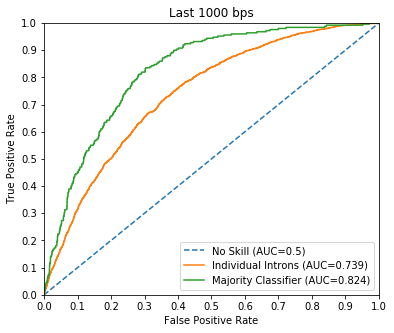

In [56]:
plot_roc_curve_multi([(y_last, y_last_pred), (y_gene_last, y_gene_last_pred)], 
                     ['Individual Introns', 'Majority Classifier'], title="Last 1000 bps")

### First 1000 Classification

In [25]:
# First 1000 classifier on first 1000 sequences
y_first, y_first_pred = classify_introns(model_first, test_seqs_first_hot)
y_gene_first, y_gene_first_pred = classify_genes(model_first, test_seqs_first_hot)

100%|██████████| 2451/2451 [01:36<00:00, 25.51it/s]


Individual Introns ROC AUC=0.747
Majority Classifier ROC AUC=0.843


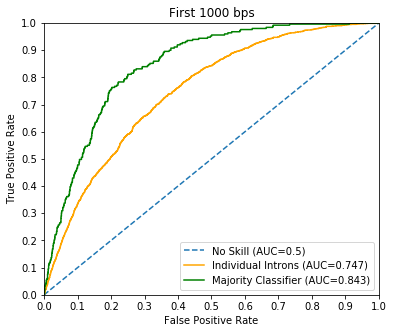

In [57]:
plot_roc_curve_multi([(y_first, y_first_pred), (y_gene_first, y_gene_first_pred)], 
                     ['Individual Introns', 'Majority Classifier'], title="First 1000 bps",
                     color_order=["orange", "green"])

### Double Majority Classifier

In [27]:
# double up models for majority classifier
y_double, y_double_pred = classify_genes(model_last, test_seqs_last_hot, second_model=model_first,
                                         second_seqs_hot=test_seqs_first_hot)

100%|██████████| 2451/2451 [03:06<00:00, 13.12it/s]


First 1000 bp Majority ROC AUC=0.843
Last 1000 bp Majority ROC AUC=0.824
Double Classifier ROC AUC=0.857
saving...


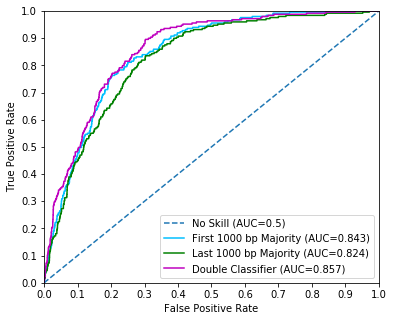

In [119]:
plot_roc_curve_multi([(y_gene_first, y_gene_first_pred), (y_gene_last, y_gene_last_pred), (y_double, y_double_pred)], 
                     ['First 1000 bp Majority', 'Last 1000 bp Majority', 'Double Classifier'],
                    color_order=["deepskyblue", "green", 'm'],
                    saveas="majority_roc_curves.png")

First 1000 bp ROC AUC=0.747
Last 1000 bp ROC AUC=0.739
First 1000 bp Majority ROC AUC=0.843
Last 1000 bp Majority ROC AUC=0.824
Double Classifier ROC AUC=0.857
saving...


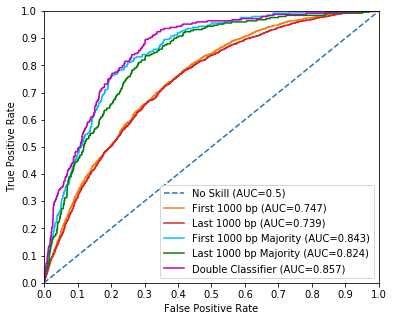

In [117]:
# Everything plot
plot_roc_curve_multi([(y_first, y_first_pred), (y_last, y_last_pred), (y_gene_first, y_gene_first_pred), (y_gene_last, y_gene_last_pred), (y_double, y_double_pred)], 
                     ['First 1000 bp', 'Last 1000 bp', 'First 1000 bp Majority', 'Last 1000 bp Majority', 'Double Classifier'],
#                      color_order=['orange', 'green', 'red', 'purple', 'brown'],
                     color_order=['tab:orange', 'tab:red', 'deepskyblue', 'green', 'm'],
                     #style_order=['-', '-', '--', '--', '-'])
                    saveas="all_roc_curves.png")


### First Introns Only

In [30]:
y_first_intron1, y_first_pred_intron1 = classify_introns(model_first, test_seqs_first_hot, first_only=True)
y_last_intron1, y_last_pred_intron1 = classify_introns(model_last, test_seqs_last_hot, first_only=True)

100%|██████████| 2451/2451 [01:35<00:00, 25.64it/s]


In [31]:
# 
y_double_intron1, y_double_pred_intron1 = classify_genes(model_first, test_seqs_first_hot, 
                                                         model_last,  test_seqs_last_hot, first_only=True)

100%|██████████| 2451/2451 [03:02<00:00, 13.42it/s]


All Introns (First 1000 bp) ROC AUC=0.747
All Introns (Last 1000 bp) ROC AUC=0.739
First Introns (First 1000 bp) ROC AUC=0.792
First Introns (Last 1000 bp) ROC AUC=0.791
First Introns (Majority) ROC AUC=0.835
saving...


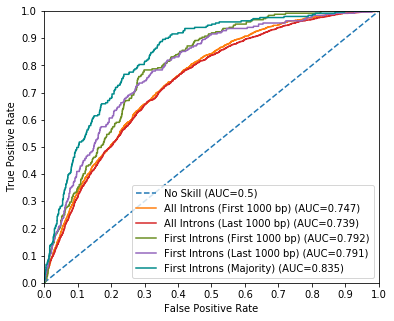

In [123]:
plot_roc_curve_multi([(y_first, y_first_pred), (y_last, y_last_pred),
                     (y_first_intron1, y_first_pred_intron1), (y_last_intron1, y_last_pred_intron1),
                     (y_double_intron1, y_double_pred_intron1)], 
                     ['All Introns (First 1000 bp)', 'All Introns (Last 1000 bp)', 
                      'First Introns (First 1000 bp)', 'First Introns (Last 1000 bp)',
                     'First Introns (Majority)'],
                     saveas="first_introns.png",
                     color_order=['tab:orange', 'tab:red', 'olivedrab', 'tab:purple', 'darkcyan'])
#                      style_order=['-', ':', '-', ':'])

### Essential/Nonessential Only

In [33]:
# Only consider essential/nonessential (i.e. ignore conditional)
test_seqs_hot_binary_first = {gene:v for gene,v in intron_seqs_first_hot.items() if gene in genes_test and essentialities[gene] != 1}
test_seqs_hot_binary_last = {gene:v for gene,v in intron_seqs_last_hot.items() if gene in genes_test and essentialities[gene] != 1}

In [34]:
y_double_binary, y_double_pred_binary = classify_genes(model_last, test_seqs_hot_binary_last, second_model=model_first,
                                         second_seqs_hot=test_seqs_hot_binary_first)

100%|██████████| 2232/2232 [02:49<00:00, 13.16it/s]


Double Classifier ROC AUC=0.857
Double Classifier (No Conditional) ROC AUC=0.858


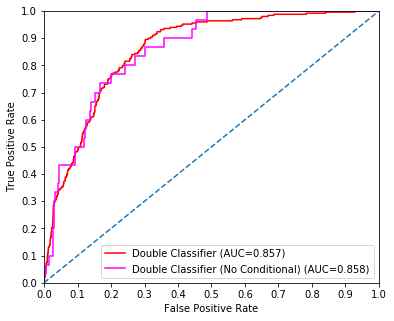

In [35]:
plot_roc_curve_multi([(y_double, y_double_pred), (y_double_binary, y_double_pred_binary)], 
                     ['Double Classifier', 'Double Classifier (No Conditional)'],
                     color_order=['red', 'fuchsia'])

First 1000 ROC AUC=0.747
Last 1000 ROC AUC=0.739
First 1000 Majority ROC AUC=0.843
Last 1000 Majority ROC AUC=0.824
Double Classifier ROC AUC=0.857
Double Classifier (No Conditional) ROC AUC=0.858


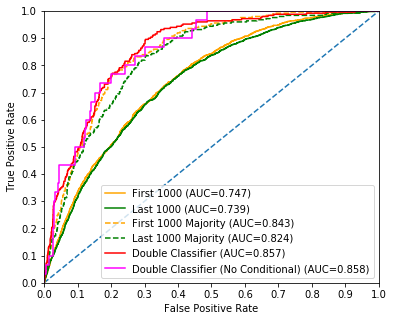

In [36]:
# Everything plot
plot_roc_curve_multi([(y_first, y_first_pred), (y_last, y_last_pred), (y_gene_first, y_gene_first_pred), (y_gene_last, y_gene_last_pred), (y_double, y_double_pred), (y_double_binary, y_double_pred_binary)], 
                     ['First 1000', 'Last 1000', 'First 1000 Majority', 'Last 1000 Majority', 'Double Classifier', 'Double Classifier (No Conditional)'],
                     color_order=['orange', 'green', 'orange', 'green', 'red', 'fuchsia'],
                     style_order=['-', '-', '--', '--', '-', '-'] )